In [1]:
import glob
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# concat vnondb-word
train_df = pd.read_csv('../../vnondb_word/train_word.csv', sep='\t')
test_df = pd.read_csv('../../vnondb_word/test_word.csv', sep='\t')
validation_df = pd.read_csv('../../vnondb_word/validation_word.csv', sep='\t')

result = pd.concat([train_df, test_df, validation_df])

result.to_csv('../../vnondb_word/vnondb_word_all.csv', index=False, sep='\t')

In [6]:
def words_info(f_list):
    df = pd.read_csv(f_list, sep='\t')
    words_list = df.loc[:, 'label'].astype(str)
    
    words_count = words_list.value_counts()
    
    words_len = Counter(words_list.str.len().values.astype(int))
    
    letters_count = Counter(sorted(''.join(words_list)))
    
    return words_count, letters_count, words_len

# ALL SET

In [21]:
_, all_letters_count, _ = words_info('../../vnondb_word/vnondb_word_all.csv')

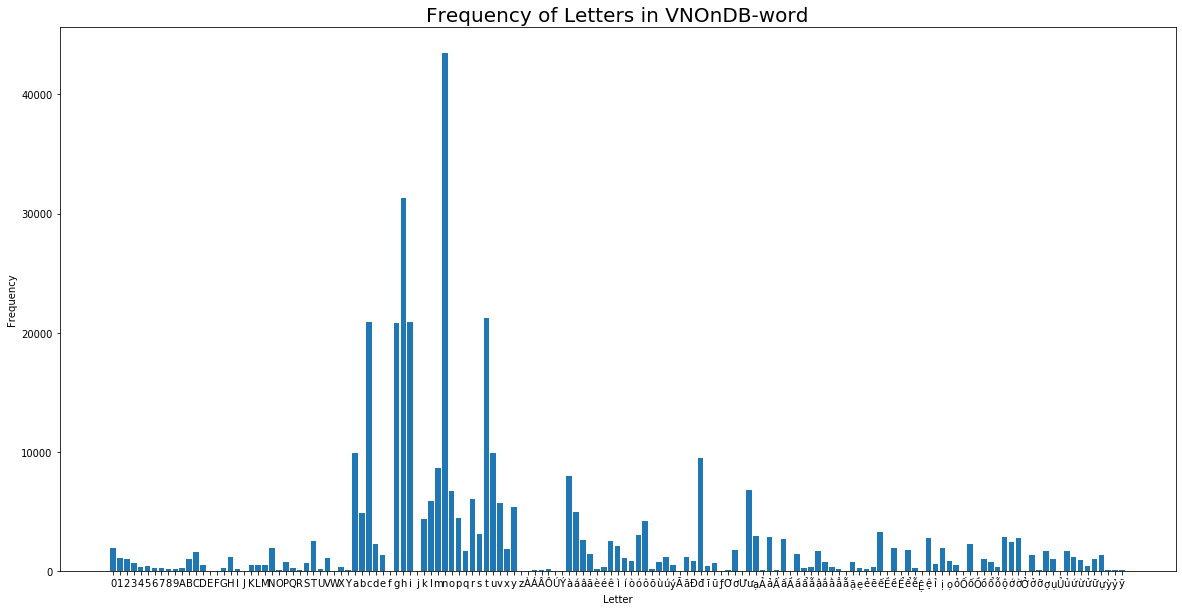

In [22]:
# all letters
fig = plt.figure(figsize=(20,10))
plt.bar(all_letters_count.keys(), all_letters_count.values())

plt.title('Frequency of Letters in VNOnDB-word', fontsize=20)
plt.xlabel('Letter', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

fig.savefig('word_all/letter_frequency.jpg', dpi=300)

# TRAIN SET

In [24]:
_, train_letters_count, _ = words_info('../../vnondb_word/train_word.csv')

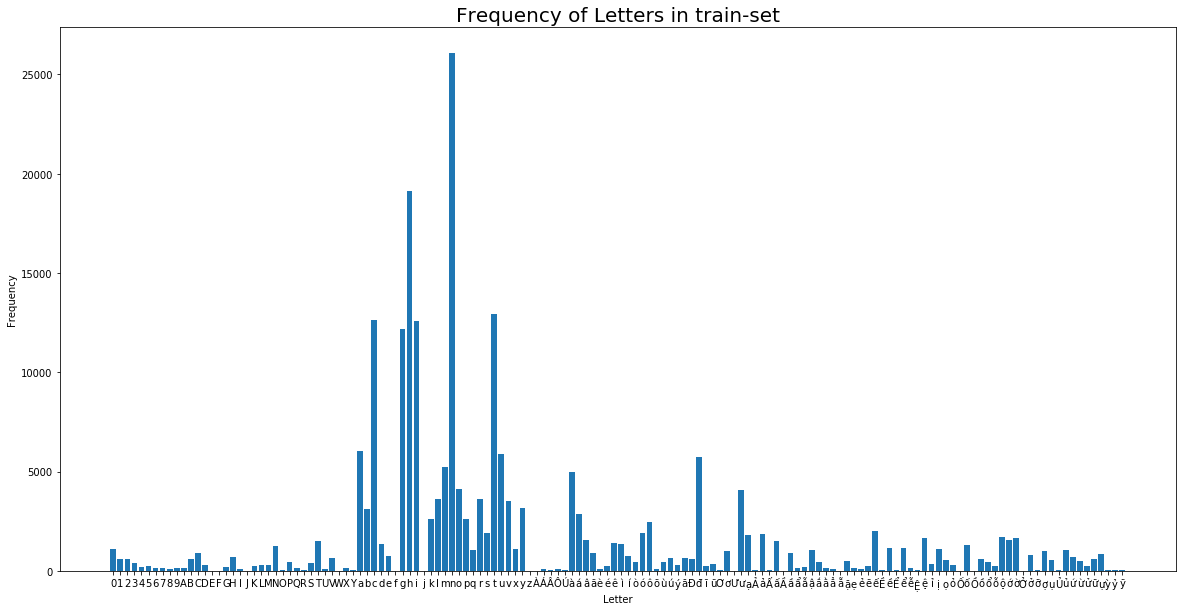

In [25]:
# all letters
fig = plt.figure(figsize=(20,10))
plt.bar(train_letters_count.keys(), train_letters_count.values())

plt.title('Frequency of Letters in train-set', fontsize=20)
plt.xlabel('Letter', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

fig.savefig('word_train/train_letter_frequency.jpg', dpi=300)

# VALIDATION SET

In [26]:
_, validation_letters_count, _ = words_info('../../vnondb_word/validation_word.csv')

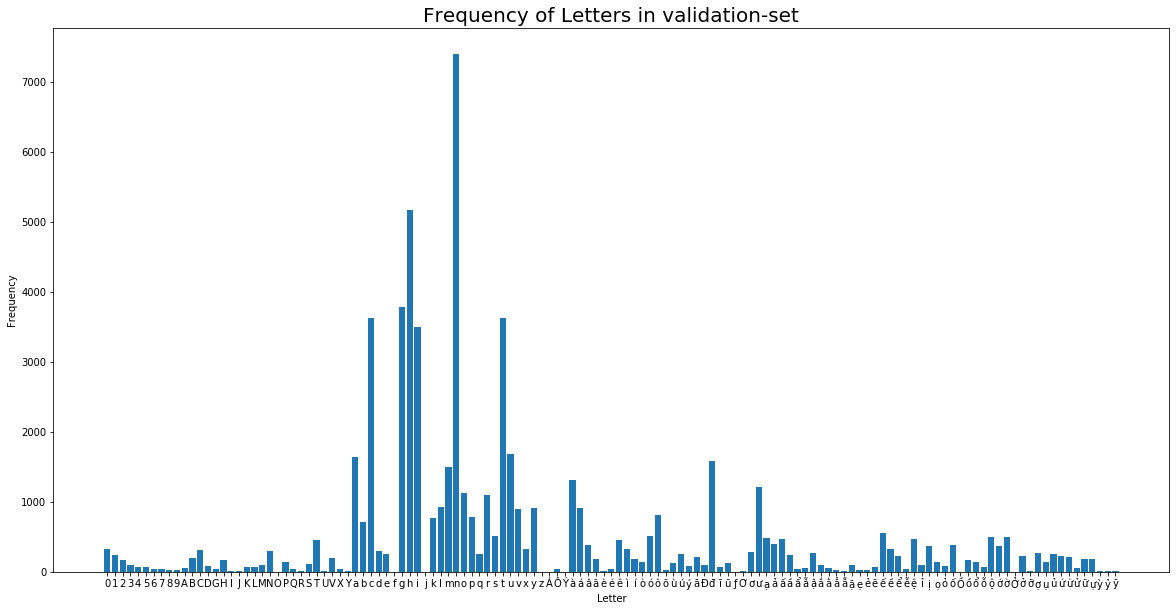

In [29]:
# all letters
fig = plt.figure(figsize=(20,10))
plt.bar(validation_letters_count.keys(), validation_letters_count.values())

plt.title('Frequency of Letters in validation-set', fontsize=20)
plt.xlabel('Letter', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

fig.savefig('word_validation/validation_letter_frequency.jpg', dpi=300)

# TEST SET

In [28]:
_, test_letters_count, _ = words_info('../../vnondb_word/test_word.csv')

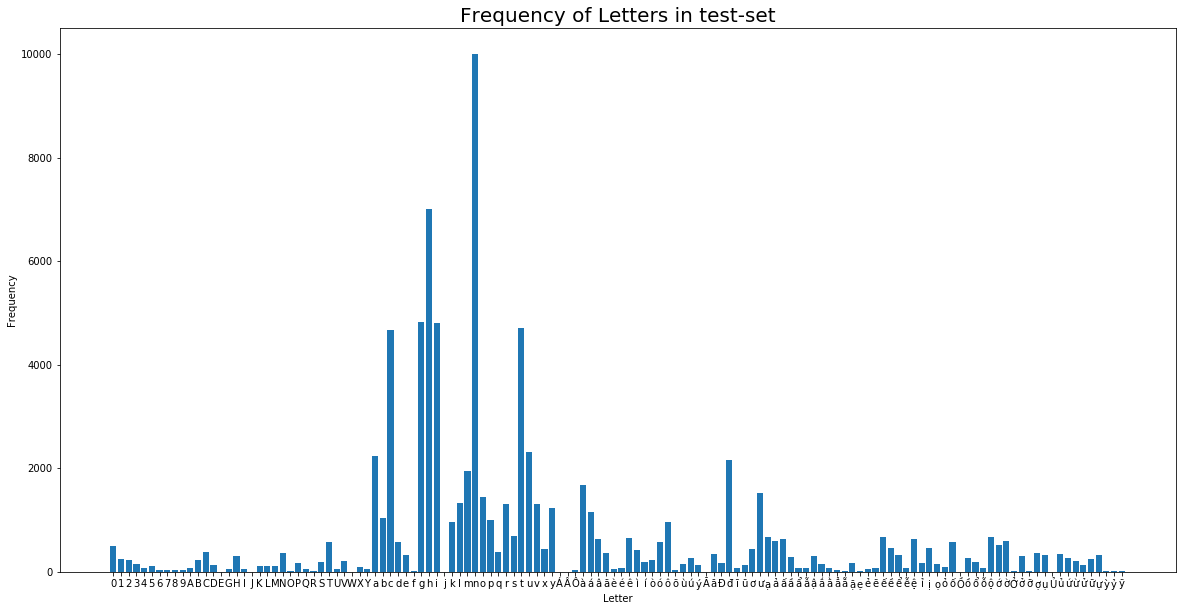

In [30]:
# all letters
fig = plt.figure(figsize=(20,10))
plt.bar(test_letters_count.keys(), test_letters_count.values())

plt.title('Frequency of Letters in test-set', fontsize=20)
plt.xlabel('Letter', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

fig.savefig('word_test/test_letter_frequency.jpg', dpi=300)

In [40]:
# Missing
print(f'Number of letters in all: {len(all_letters_count)}')
print(f'Number of letters in train-set: {len(train_letters_count)}')
print(f'Number of letters in validation-set: {len(validation_letters_count)}')
print(f'Number of letters in test-set: {len(test_letters_count)}')
print(f'train-set missing: {all_letters_count.keys() - train_letters_count.keys()}')
print(f'validation-set missing: {all_letters_count.keys() - validation_letters_count.keys()}')
print(f'test-set missing: {all_letters_count.keys() - test_letters_count.keys()}')

Number of letters in all: 147
Number of letters in train-set: 144
Number of letters in validation-set: 131
Number of letters in test-set: 132
train-set missing: {'Ă', 'Ý', 'ƒ'}
validation-set missing: {'W', 'Ủ', 'E', 'Ă', 'Â', 'Ề', 'F', 'Ệ', 'Ấ', 'Ư', 'Ả', 'Ú', 'Ố', 'À', 'Ể', 'Ầ'}
test-set missing: {'Ệ', 'Ấ', 'Ý', 'ƒ', 'Ư', 'Ả', 'z', 'Ú', 'Ố', 'Ơ', 'À', 'Ể', 'Ầ', 'Ề', 'F'}
